# Рейтинг видов шоколада

Как сделать хороший, вкусный шоколад, который понравится потребителям? Вопрос, ответ на который хотели бы узнать многие компании-изготовители! Ответить на него (и на несколько возникших по ходу исследования вопросов) мне помог следующий датасет.

Файлы с кодом и данными можно найти в [репозитории](https://github.com/AlexandrosDaSilva/chocolate_rating).

In [175]:
# Загружаем библиотеки
import numpy as np # работа с векторами
import matplotlib.pyplot as plt # рисовать графики
import pandas as pd # для работы с матрицами
import os as os #для смены директории
import seaborn as sns
import eli5
import lime

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer

# Установим директорию для загрузки данных для модели
os.chdir('/Users/alexander')

# Загружаем данные
df = pd.read_csv('flavors_of_cacao.csv', encoding = 'latin1')
df = df.dropna()
df.head()

,CompanyÂ (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,Â,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,Â,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,Â,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,Â,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,Â,Peru


Сразу переименуем столбцы для удобства работы с ними, а также устраним проблемы с кодировкой.

In [176]:
# Для удобства сразу переименуем столбцы
df.columns = ['Company', 'Name', 'Recent', 'Year', 'Cocoa', 'Company Location', 'Rating', 'Type', 'Country']
# Устранение проблем с кодировкой
df = df[df['Country'] != 'Â\xa0']
df.replace('Â\xa0', 'Other', inplace = True)

### Теперь можно описать данные.

* _Company_ - имя компании-производителя;
* _Name_ - название шоколада;
* _Recent_ - параметр, который показывает, насколько недавней является оценка;
* _Year_ - год, в котором была выставлена оценка;
* _Cocoa_ - процент содержания какао;
* _Company Location_ - страна, в которой базируется компания-изготовитель;
* _Rating_ - рейтинг шоколада;
* _Type_ - сорт какао-бобов;
* _Country_ - страна, в которой были выращены какао-бобы.

Теперь произведём некоторую "чистку" данных, а именно удалим столбцы, которые не будем использовать, исправим опечатки, а также переведём данные в столбце 'Cocoa' к числовому типу.

In [177]:
df = df.drop(['Recent', 'Name'], axis = 1)
for s in df['Cocoa']:
    df.replace(s, float(s[:-1]), inplace = True)
    
df['Country'].replace(['Cost ', '/', 'Mad.', 'Madagascar & Ecuador', ' and', 'Peru(SMartin,Pangoa,nacional)',
                       'Carribean(DR/Jam/Tri)', 'Ghana & Madagascar', 'Rep.', 'Domincan', 'Dom. Rep'],
                      ['Costa', ',', 'Madagascar', 'Madagascar, Ecuador', ',', 'Peru',
                       'Dominican Republic, Jamaica, Trinidad', 'Ghana, Madagascar', 'Republic', 'Dominican',
                       'Dominican Republic'],
                      inplace = True)
df['Company Location'].replace(['Amsterdam', 'Niacragua', 'Domincan'],
                               ['Netherlands', 'Nicaragua', 'Dominican'], inplace = True)

Посмотрим теперь, сколько у нас видов шоколада, содержащего какао-бобы из разных стран.

In [178]:
(df['Country'].str.count(',')+1).value_counts()

1    1679
2      25
3      12
5       3
4       1
Name: Country, dtype: int64

Заведём новый параметр _Blend_, который будет показывать, смешивали ли сорта бобов для изготовления этого шоколада.

In [179]:
isblend = df['Country'].str.count(',') > 0
df['Blend'] = isblend

Возвращаясь к исходной задаче, построим график распределения рейтингов шоколада.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


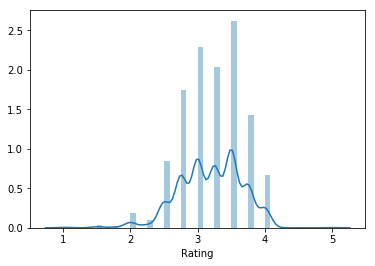

In [180]:
sns.distplot(df['Rating'])

In [181]:
df[df['Rating'] >= 4].shape[0]

96

Будем считать шоколад с рейтингом 4 или больше хорошим. Сделаем даже отдельный столбец _IsGood_, показывающий, является ли шоколад хорошим. Посмотрим, как теперь выглядят наши данные.

In [182]:
df['IsGood'] = df['Rating'] >= 4
df.head(10)

,Company,Year,Cocoa,Company Location,Rating,Type,Country,Blend,IsGood
0,A. Morin,2016,63.0,France,3.75,Other,Sao Tome,False,False
1,A. Morin,2015,70.0,France,2.75,Other,Togo,False,False
2,A. Morin,2015,70.0,France,3.00,Other,Togo,False,False
3,A. Morin,2015,70.0,France,3.50,Other,Togo,False,False
4,A. Morin,2015,70.0,France,3.50,Other,Peru,False,False
5,A. Morin,2014,70.0,France,2.75,Criollo,Venezuela,False,False
6,A. Morin,2014,70.0,France,3.50,Other,Cuba,False,False
7,A. Morin,2014,70.0,France,3.50,Criollo,Venezuela,False,False
8,A. Morin,2014,70.0,France,3.75,Criollo,Venezuela,False,False
9,A. Morin,2014,70.0,France,4.00,Other,Peru,False,True


Сразу посмотрим, какао-бобы какого вида чаще встречаются среди всех видов шоколада и среди шоколада с хорошим рейтингом (выведем 5 самых популярных в каждом из случаев):

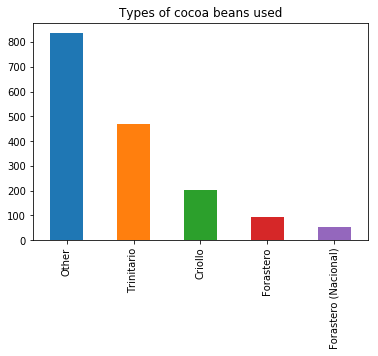

In [183]:
types = []
for bean in df['Type']:
    t = bean.split(',')
    types += t
types = list(filter(len, types))
types = list(map(lambda x: x.strip(), types))
pd.Series(types).value_counts().head().plot(kind = 'bar', title = 'Types of cocoa beans used')

Видно, что из 1720 видов шоколада почти 500 (т.е. почти треть) составляет шоколад, в составе которого есть какао-бобы __Trinitario__ и около 200 видов (т.е. около 11%) содержат какао-бобы вида __Criollo__.

Для хорошего шоколада ситуация несколько меняется:

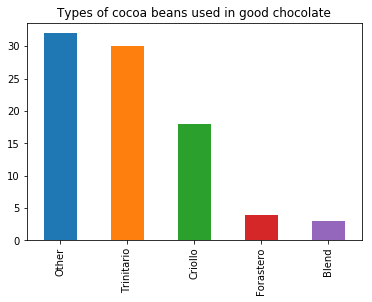

In [184]:
typesg = []
for bean in df[df['Rating'] >= 4]['Type']:
    t = bean.split(',')
    typesg += t
typesg = list(filter(len, typesg))
typesg = list(map(lambda x: x.strip(), typesg))
pd.Series(typesg).value_counts().head().plot(kind = 'bar', title = 'Types of cocoa beans used in good chocolate')

Из 96 видов хорошего шоколада у нас всё так же примерно треть содержит какао-бобы сорта __Trinitario__. А вот процент шоколада, содержащего бобы __Criollo__ поднимается до 17%!

Сравним теперь процент содержания какао во всех видах шоколада и в хорошем шоколаде.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


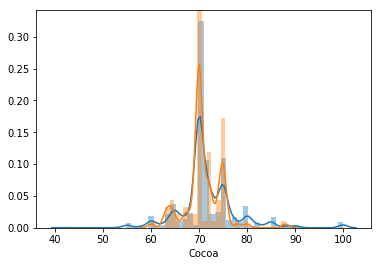

In [185]:
sns.distplot(df['Cocoa'])
sns.distplot(df[df['Rating'] >= 4]['Cocoa'])

Можно заметить, что распределения очень похожи, а также что 70%-шоколад составляет треть от общего числа видов шоколада.

Для построения следующих графиков и модели нам нужно перевести все переменные в числовые (кроме столбца _Type_, потому что для построения модели мы его использовать не будем). Создадим словарь _keys_, где будут записаны все соответствия между присвоенными номерами и названиями стран/компаний.

In [186]:
keys = {}
for i in range(pd.unique(df['Country']).shape[0]):
    keys[np.array(range(200, 200 + pd.unique(df['Country']).shape[0]))[i]] = pd.unique(df['Country'])[i]
for i in range(pd.unique(df['Company Location']).shape[0]):
    keys[np.array(range(500, 500 + pd.unique(df['Company Location']).shape[0]))[i]] =\
    pd.unique(df['Company Location'])[i]
for i in range(pd.unique(df['Company']).shape[0]):
    keys[np.array(range(1000, 1000 + pd.unique(df['Company']).shape[0]))[i]] = pd.unique(df['Company'])[i]

df['Country'].replace(pd.unique(df['Country']), np.array(range(200, 200 + pd.unique(df['Country']).shape[0])),
           inplace = True)
df['Company Location'].replace(pd.unique(df['Company Location']),
                               np.array(range(500, 500 + pd.unique(df['Company Location']).shape[0])), inplace = True)
df['Company'].replace(pd.unique(df['Company']), np.array(range(1000, 1000 + pd.unique(df['Company']).shape[0])),
           inplace = True)
df.replace([True, False], [1, 0], inplace = True)
df.head()

,Company,Year,Cocoa,Company Location,Rating,Type,Country,Blend,IsGood
0,1000,2016,63.0,500,3.75,Other,200,0,0
1,1000,2015,70.0,500,2.75,Other,201,0,0
2,1000,2015,70.0,500,3.00,Other,201,0,0
3,1000,2015,70.0,500,3.50,Other,201,0,0
4,1000,2015,70.0,500,3.50,Other,202,0,0


Теперь посмотрим, в каких странах базируются компании, производящие хороший шоколад.

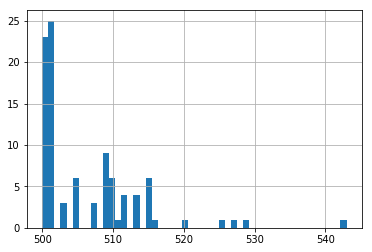

In [187]:
df[df['Rating'] >= 4]['Company Location'].hist(bins = 50)

In [188]:
print(df[np.logical_and(df['Rating'] >= 4, df['Company Location'] <= 501)]['Company Location'].shape[0]/ \
df[df['Rating'] >= 4]['Company Location'].shape[0])
print(keys[500], ',', keys[501])

0.5
France , U.S.A.


Получается, __<font color=green>половину</font>__ хорошего шоколада производят компании в двух странах: США и Франции (26% и 24% соответственно)!

В каких же странах собирают какао-бобы для хорошего шоколада?

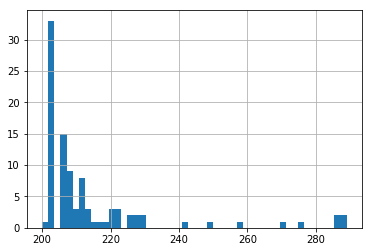

In [189]:
df[df['Rating'] >= 4]['Country'].hist(bins = 50)

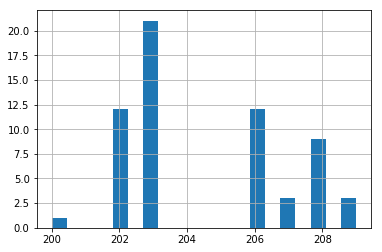

In [190]:
df[np.logical_and(df['Rating'] >= 4, df['Country'] <= 210)]['Country'].hist(bins = 20)

In [191]:
print(keys[203])
print(keys[202], ',', keys[206])

Venezuela
Peru , Madagascar


Довольно большую долю (24%) собирают в Венесуэле, следующими идут Перу и Мадагаскар (по 12,5%).

Убедимся теперь, что между нашими переменными нет очевидных зависимостей.

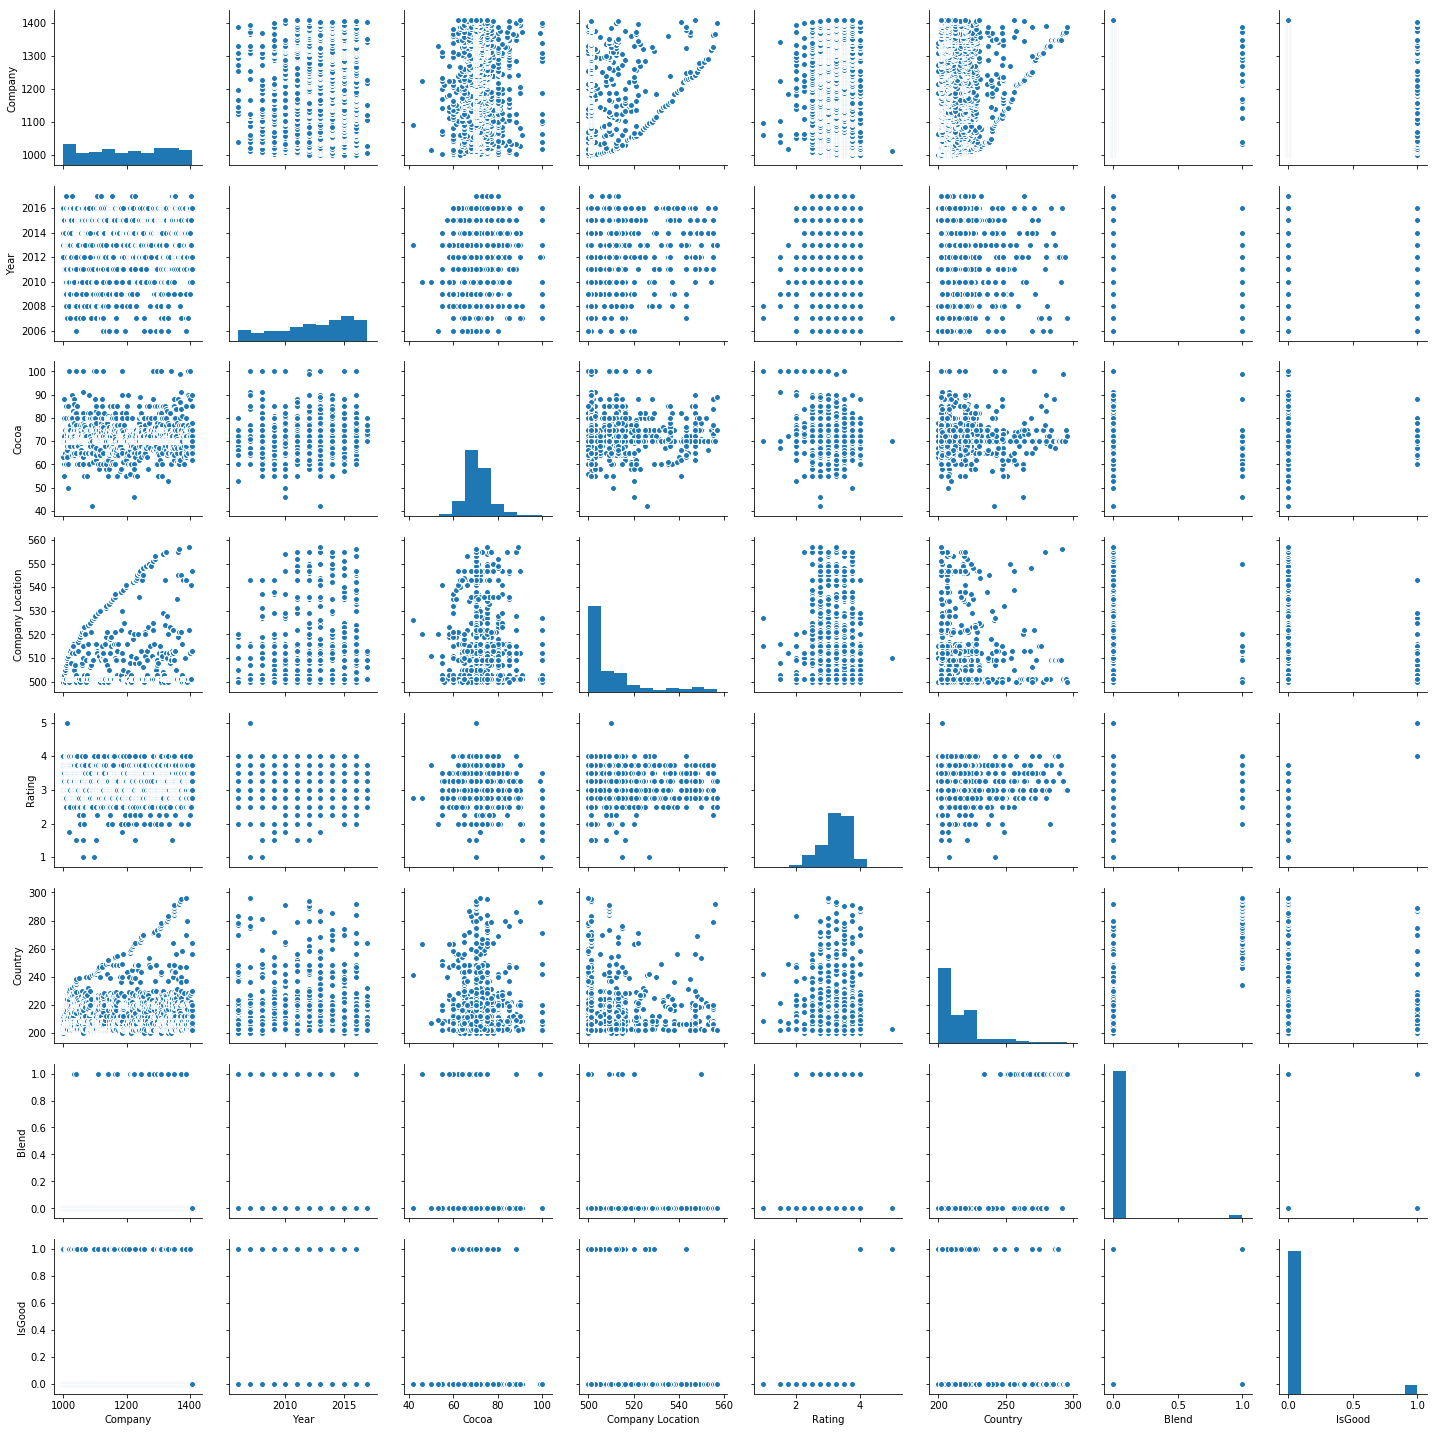

In [192]:
sns.pairplot(df)

## Построение модели

Будем решать задачу кластеризации: определять, получится шоколад хорошим или не очень, исходя из таких параметров как процент содержания какао, страну, в которой были собраны эти какао-бобы, является ли эта страна единственной (или были смешаны бобы из разных стран).

Для этого воспользуемся деревом решений.

In [214]:
X = df[['Cocoa', 'Country', 'Blend']].values
y = df['IsGood'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [215]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

[[533  12]
 [ 28   1]]
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       545
          1       0.08      0.03      0.05        29

avg / total       0.91      0.93      0.92       574

0.9520069808027923
0.9303135888501742


In [216]:
mse = np.mean((y_pred - y_test)**2)
mse

0.0708822493899404

Получилась очень даже хорошая точность предсказания!

Разберёмся теперь, какие параметры сильнее влияют на предсказание.

In [217]:
names = ['Cocoa', 'Country', 'Blend']
eli5.explain_weights_df(tree, feature_names = names)

,feature,weight
0,Country,0.513334
1,Cocoa,0.466701
2,Blend,0.019966


Также можно ещё отметить, как эти параметры повлияли на итоговый выбор в конкретных случаях (локальная интерпретация).

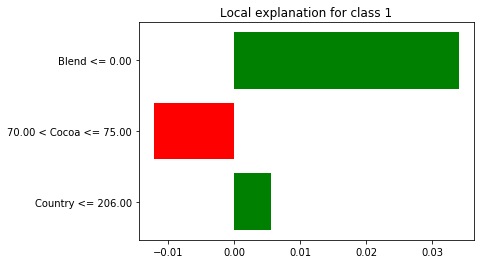

In [218]:
explainer = LimeTabularExplainer(X_train, mode = 'classification', feature_names = names)
exp = explainer.explain_instance(X_test[7,:], tree.predict_proba)
exp.as_pyplot_figure();
exp.show_in_notebook()

Из этих графиков видно, что в пользу того, чтобы оценить этот вид шоколада хорошо, говорят такие факторы как то, что:

1. В состав шоколада входят какао-бобы только одного сорта;
2. Страна, в которой выращены какао-бобы, является одной из следующих:

In [219]:
for i in range(200, 207):
    print(keys[i])

Sao Tome
Togo
Peru
Venezuela
Cuba
Panama
Madagascar


При этом тот факт, что процент содержания какао > 70 и $\leq$ 75, влияет на предсказание в обратную сторону и увеличивает вероятность того, что полученный шоколад не будет высоко оценён потребителями.

#### Вывод.
Основываясь на этой модели, нужно отметить, что для изготовителя шоколада очень важно, во-первых, правильно выбрать страну, из которой будут завезены какао-бобы. Во-вторых, необходимо учитывать процентное содержание какао в изготавливаемом продукте. И, в большинстве случаев, смешивать разные сорта какао-бобов - не очень хорошая идея :)